In [46]:
from scipy.io import wavfile
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt

In [47]:
def read_wav(file):
    samplerate, data = wavfile.read('{}.wav'.format(file))
    print(samplerate,data.shape)
    return samplerate,data
fs1,x1 = read_wav('x1')
fs2,x2 = read_wav('x2')
fs3,x3 = read_wav('x3')
fs_s1,s1 = read_wav('s1')
fs_s2,s2 = read_wav('s2')
fs_s3,s3 = read_wav('s3')

44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)
44100 (441000,)


In [48]:
# 標準化
M = len(x1)#信号のサンプル数
x = np.zeros((3, len(x1)))
x[0,:] = (x1 - np.mean(x1))/np.sqrt(np.nanvar(x1))
x[1,:] = (x2 - np.mean(x2))/np.sqrt(np.nanvar(x2))
x[2,:] = (x3 - np.mean(x3))/np.sqrt(np.nanvar(x3))
print(x.shape)

# 観測信号の白色化化
R = np.dot(x, x.T)/M
eig_v, Q = np.linalg.eig(R)
Lambda = np.diag(eig_v)
V = np.dot(np.sqrt(np.linalg.inv(Lambda)), Q.T)
xh = np.dot(V,x)
print(xh.shape)

def ICA(m_component, max_iter):
  b_past = np.eye(m_component)
  b = np.eye(m_component)
  sh = np.zeros((m_component,xh.shape[1]))
  for m in range (m_component):
    for i in range(max_iter):
      b_past[:, m] = b[:,m]
      sh[m,:] = np.dot(b[:,m].T, xh)
      b[0,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[0,:])) - 3*b[0,m]
      b[1,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[1,:])) - 3*b[1,m]
      b[2,m] = np.mean(np.dot(np.power(sh[m,:], 3), xh[2,:])) - 3*b[2,m]
      if (m > 0):
        for j in range(m):
          b[0,m] -= (b[0,m].T*b[0,j])*b[0,j]
          b[1,m] -= (b[1,m].T*b[1,j])*b[1,j]
          b[2,m] -= (b[2,m].T*b[2,j])*b[2,j]
      b[:,m] = b[:,m]/np.linalg.norm(b[:,m])
      if np.abs(np.abs(np.dot(b[:,m].T, b_past[:, m]))-1) < 10**-6:
        break
    print(i)
  return sh


    # for i in range(100):
    #   b_past[:, 1] = b[:,1]
    #   sh2 = np.dot(b[:,1].T, xh)
    #   b[0,1] = np.mean(np.dot(np.power(sh2, 3), xh[0,:])) - 3*b[0,1] - ((np.mean(np.dot(np.power(sh2, 3), xh[0,:])) - 3*b[0,1]).T*b[0,0])*b[0,0]
    #   b[1,1] = np.mean(np.dot(np.power(sh2, 3), xh[1,:])) - 3*b[1,1] - ((np.mean(np.dot(np.power(sh2, 3), xh[1,:])) - 3*b[1,1]).T*b[1,0])*b[1,0]
    #   b[2,1] = np.mean(np.dot(np.power(sh2, 3), xh[2,:])) - 3*b[2,1] - ((np.mean(np.dot(np.power(sh2, 3), xh[2,:])) - 3*b[2,1]).T*b[2,0])*b[2,0]
    #   b[:,1] = b[:,1]/np.linalg.norm(b[:,1])
    #   if np.abs(np.abs(np.dot(b[:,1].T, b_past[:, 1]))-1) < 10**-6:
    #     break

(3, 441000)
(3, 441000)


22
62
40
(3, 441000)


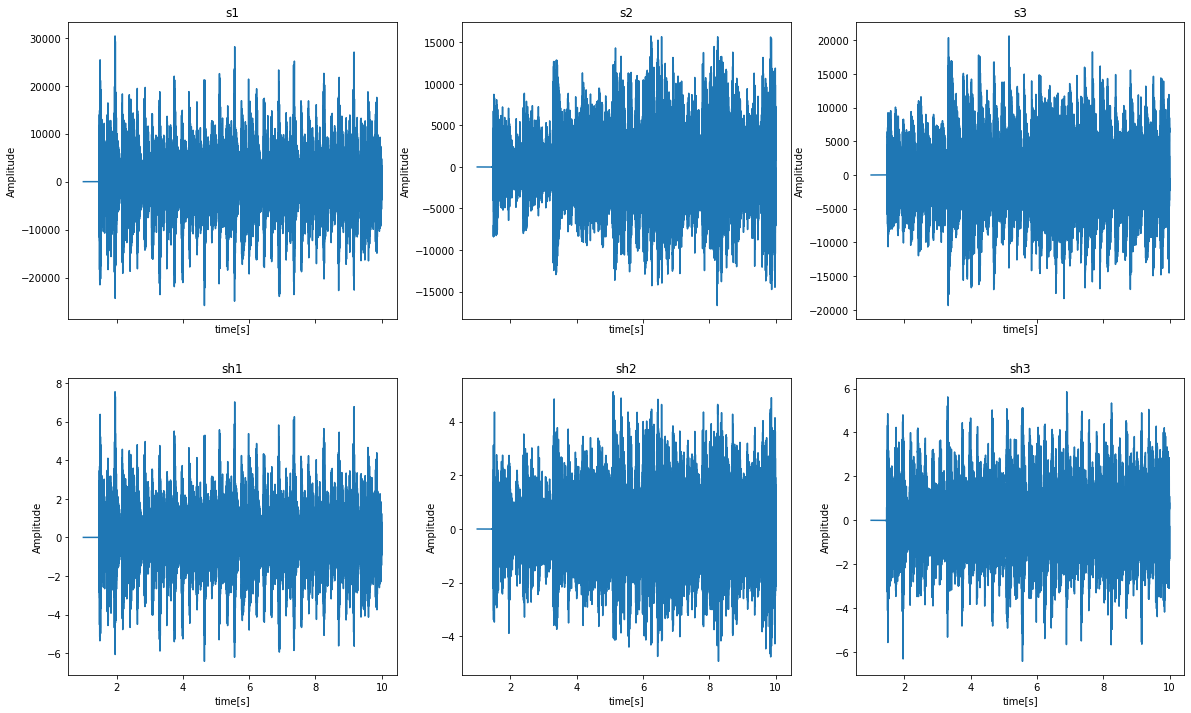

In [49]:
sh = ICA(3,100)
s = np.vstack((s1,s2,s3))
print(s.shape)
t = np.linspace(1,10,fs_s1*10)
s_title = ["s1","s2","s3"]
sh_title = ["sh1","sh2","sh3"]
fig, axs = plt.subplots(2, 3,figsize=(20, 12),sharex= True)
for i in range(2):
    if (i == 0):
        y = s
        title = s_title
    else:
        y = sh
        title = sh_title
    for j in range(3):
        axs[i, j].plot(t, y[j,:])
        axs[i, j].set_title(title[j])
for ax in axs.flat:
    ax.set(xlabel='time[s]', ylabel='Amplitude')